In [2]:
import numpy as np
import pandas as pd

from time import time
from datetime import timedelta

import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output

In [3]:
def print_elapsed_time(start):
    elapsed = timedelta(seconds=time() - start)
    # remove millis
    elapsed = str(elapsed).split('.')[0]
    print('Elapsed time: {}'.format(elapsed))

# Data collection

In [4]:
def read_tide(filepath, datetime_pattern=slice(0,13)):
    df = pd.read_csv(filepath)
    df['Date Time'] = [date[datetime_pattern] for date in df['Date Time']]
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    df = df.groupby(['Date Time']).mean()
    return df.reset_index()

In [5]:
orig_train = read_tide('BHPtraining.csv')
orig_test = read_tide('BHPtest.csv')

# Data cleaning

## Convert it to hourly

In [6]:
orig_train

,Date Time,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
0,2017-01-01 00:00:00,63.90,2.4475,0.1492,4.860,136.111111,5.355556
1,2017-01-01 01:00:00,63.98,2.2461,0.1629,4.237,134.200000,4.666000
2,2017-01-01 02:00:00,64.18,2.2506,0.1539,5.073,129.700000,5.404000
3,2017-01-01 03:00:00,64.30,2.1027,0.1608,5.015,112.200000,5.287000
4,2017-01-01 04:00:00,64.18,2.0279,0.1686,6.725,82.800000,7.115000
...,...,...,...,...,...,...,...
26275,2019-12-31 19:00:00,59.56,0.5822,0.2331,14.929,27.500000,17.630000
26276,2019-12-31 20:00:00,59.27,0.7208,0.2327,14.346,27.900000,17.027000
26277,2019-12-31 21:00:00,59.08,0.9824,0.2450,13.550,28.200000,16.327000
26278,2019-12-31 22:00:00,58.72,1.2382,0.2184,14.112,26.100000,16.619000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025DF4A7C488>,
      dtype=object)

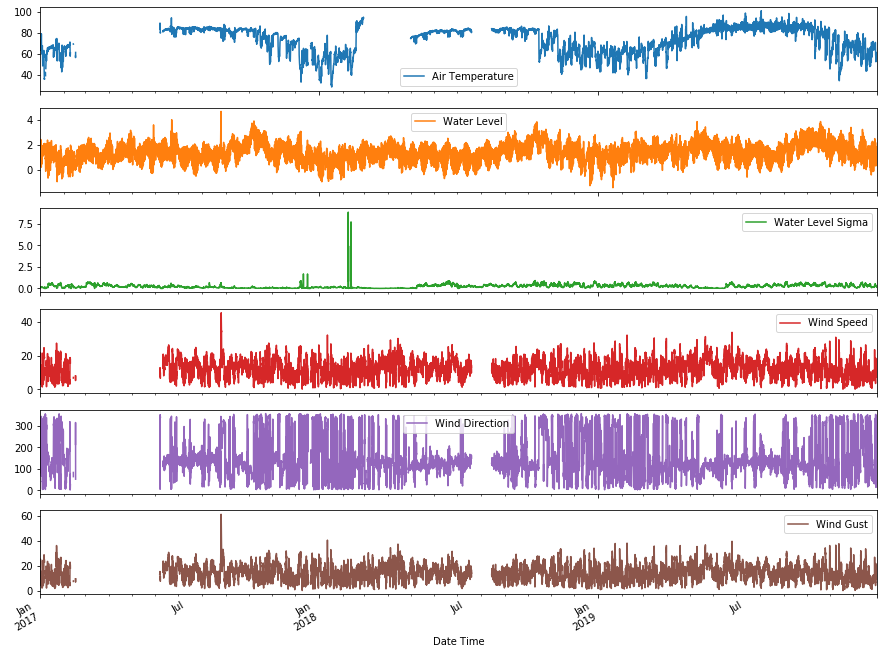

In [7]:
orig_train.plot(x='Date Time', figsize=(15, 12), subplots=True)

## Merging data and test

Merging back train and test data for easy differencing

In [8]:
merged = pd.concat([orig_train, orig_test])
merged

,Date Time,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
0,2017-01-01 00:00:00,63.900000,2.447500,0.149200,4.860000,136.111111,5.355556
1,2017-01-01 01:00:00,63.980000,2.246100,0.162900,4.237000,134.200000,4.666000
2,2017-01-01 02:00:00,64.180000,2.250600,0.153900,5.073000,129.700000,5.404000
3,2017-01-01 03:00:00,64.300000,2.102700,0.160800,5.015000,112.200000,5.287000
4,2017-01-01 04:00:00,64.180000,2.027900,0.168600,6.725000,82.800000,7.115000
...,...,...,...,...,...,...,...
7053,2020-10-20 21:00:00,80.440000,1.858000,0.385200,12.091000,74.600000,13.783000
7054,2020-10-20 22:00:00,79.770000,2.366700,0.380500,12.206000,78.600000,13.898000
7055,2020-10-20 23:00:00,79.430000,2.721800,0.384300,12.497000,74.900000,14.228000
7056,2020-10-21 00:00:00,79.320000,2.967100,0.399600,13.431000,78.600000,15.298000


## Fill missing values

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025DF33F1308>,
      dtype=object)

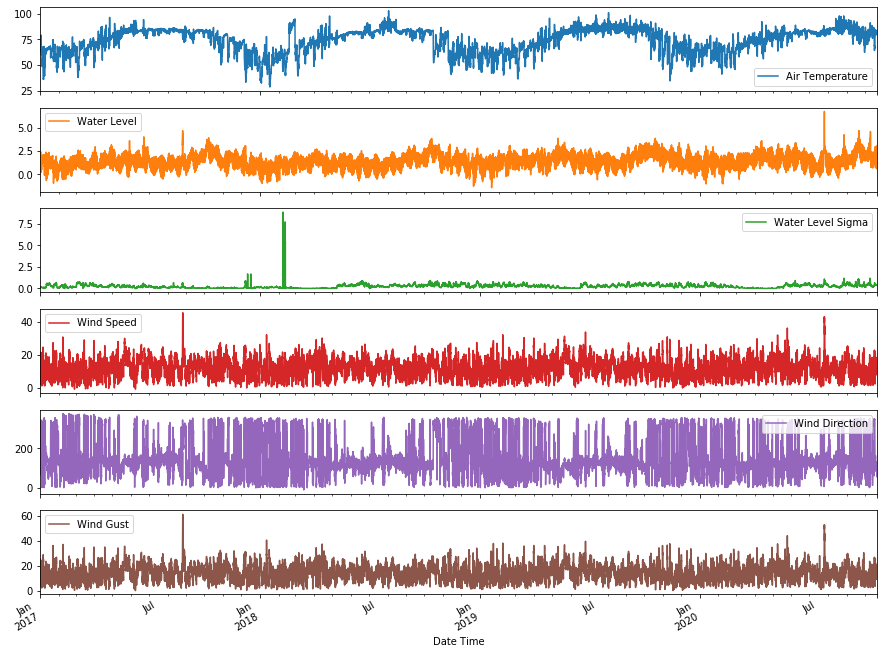

In [9]:
preprocessed = merged.copy().set_index('Date Time')
for key in preprocessed.keys():
    temp = preprocessed[key]
    nan_index = temp.isnull()
    temp = temp.interpolate('linear')
    results = seasonal_decompose(temp,period=24*30*12, model='additive', extrapolate_trend='freq')
    for i, real in enumerate(nan_index):
        if real == True:
            results.trend.iloc[i] = np.nan
            dt = '2019-' + str(results.resid.index[i])[5:]
            results.seasonal.iloc[i] = results.seasonal.loc[dt]
            results.resid.iloc[i] = results.resid.loc[dt]
    preprocessed[key] = results.trend.interpolate('linear') + results.seasonal + results.resid

preprocessed.reset_index(inplace=True)    

preprocessed.plot(x = 'Date Time', figsize=(15, 12), subplots=True)

## Stationary  test

In [10]:
def stationary_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [11]:
water_level_df = preprocessed[['Date Time', 'Water Level']].copy().set_index('Date Time')
water_level_df.dropna(inplace=True)
stationary_test(water_level_df['Water Level'].values)

ADF Statistic: -8.366553
p-value: 0.000000


The p-value is significant enough, so it might be tempted to conclude that the data is already stationary.  

However, we know that the data should be seasonal, as in below

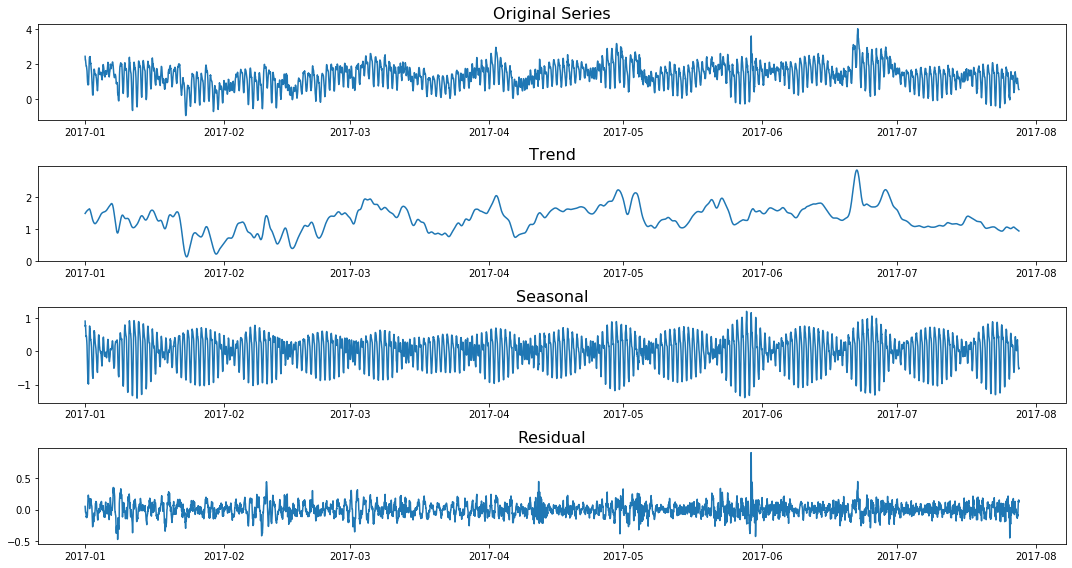

In [12]:
first_5k_obs = water_level_df['Water Level'][:5000]

stl = STL(first_5k_obs)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(15,8))

plt.subplot(4,1,1)
plt.plot(first_5k_obs)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Performing differencing

ADF Statistic: -20.239350
p-value: 0.000000


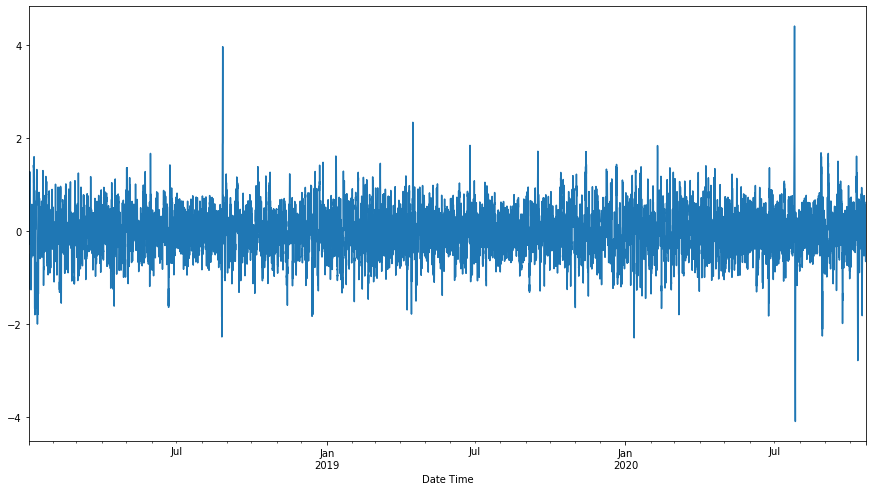

In [13]:
diff_merged = preprocessed.copy()

diff_merged = diff_merged.bfill().ffill().interpolate()
diff_merged.set_index('Date Time', inplace=True)

diff_merged = diff_merged.diff(periods=24)[1:]              # by 1 day
diff_merged = diff_merged.diff(periods=365*24).dropna()     # by 1 year

wl_df = diff_merged['Water Level']
stationary_test(wl_df)
wl_df.plot(x='Date Time', figsize=(15,8))

# diff_merged.plot(figsize=(15, 12), subplots=True)

### Splitting back into train and test set

In [14]:
boundary = pd.to_datetime('2020/01/01')
train = diff_merged[:boundary-timedelta(days=1)]
test = diff_merged[boundary:]

In [15]:
wl_train = pd.DataFrame(train['Water Level'])
wl_test = pd.DataFrame(test['Water Level'])

## ACF and PACF

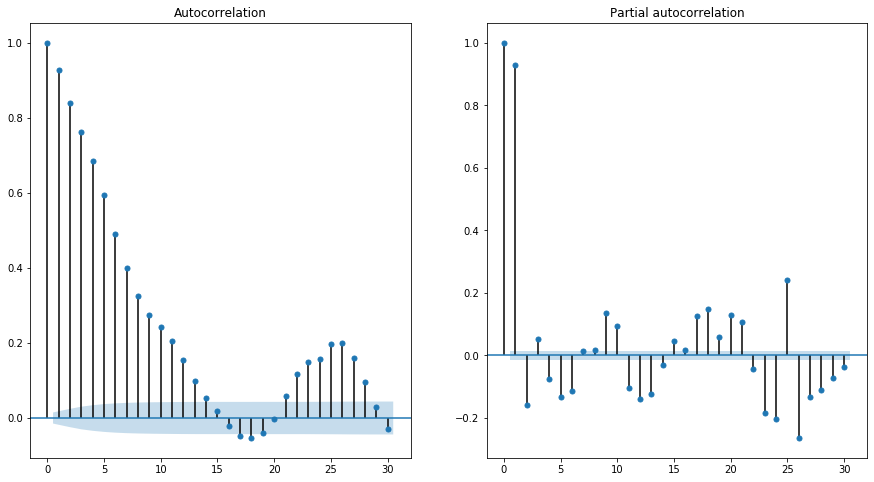

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
lags = 30
sm.graphics.tsa.plot_acf(wl_train, lags=lags, ax=ax[0], title='Autocorrelation')
sm.graphics.tsa.plot_pacf(wl_train, lags=lags, ax=ax[1], title='Partial autocorrelation')
pass

For ACF, we can see that 25 is the most significant lag, so let's try with seasonality of around 24-25.

# SARIMA model

In [55]:
def train_sarima(df, periodicity=24, p=1, q=1, trend=None, track_time=False):
    model = SARIMAX(df, order=(0,1,0), seasonal_order=(p,0,q,periodicity), trend=trend)

    #fit the model
    start = time()
    model_fit = model.fit()
    end = time()
    if track_time:
        print('Model Fitting Time:', end - start)
    
    return model_fit

### Brute-force

Let's calculate the AIC of some reasonable periods

In [17]:
periods = [6,12,18,24,25]
for period in periods:
    model = train_sarima(wl_train['Water Level'].values, period)
    print('{} {}'.format(period, model.aic))

6 -10663.603623458795
12 -12182.544265754028
18 -10817.024915202173
24 -13553.8247153439
25 -12483.64153879625


Since a period 24 hours gives lowest value of AIC, we'll try both 24 and 25.

In [18]:
model = train_sarima(wl_train['Water Level'].values)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                17473
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 24)   Log Likelihood                6779.911
Date:                              Tue, 03 Nov 2020   AIC                         -13553.823
Time:                                      02:24:03   BIC                         -13530.518
Sample:                                           0   HQIC                        -13546.148
                                            - 17473                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6714      0.005    123.535      0.000       0.661       0.682
ma.S.L24      -1.0000      0.265     -3.775      0.000      -1.519      -0.481
sigma2         0.0268      0.007      3.791      0.000       0.013       0.041
===================================================================================
Ljung-Box (L1) (Q):                 849.03   Jarque-Bera (JB):              1691.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# get the predictions and residuals
predictions = model.forecast(len(wl_test)+1)
predictions = pd.DataFrame(predictions[1:], columns=['Water Level'], index=wl_test.index)
residuals = wl_test - predictions

# predictions

,Water Level
count,7058.000000
mean,0.000985
std,0.542170
min,-4.094483
25%,-0.308558
50%,0.003617
75%,0.330954
max,4.411317


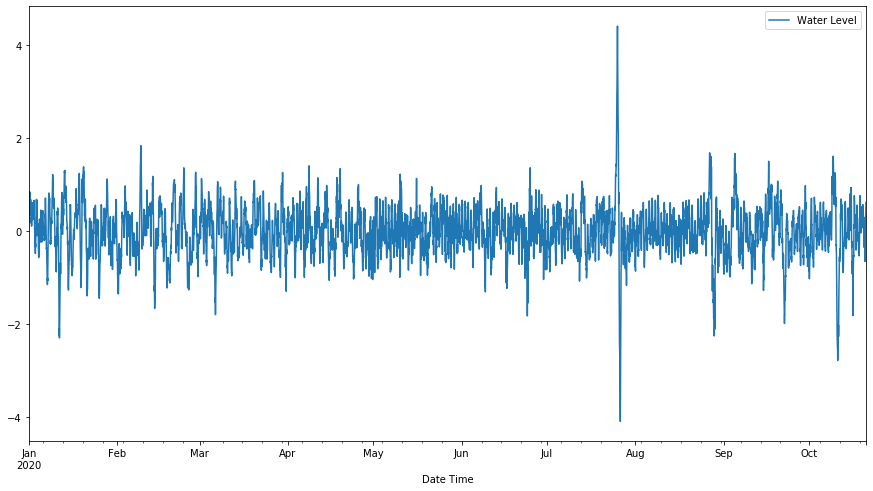

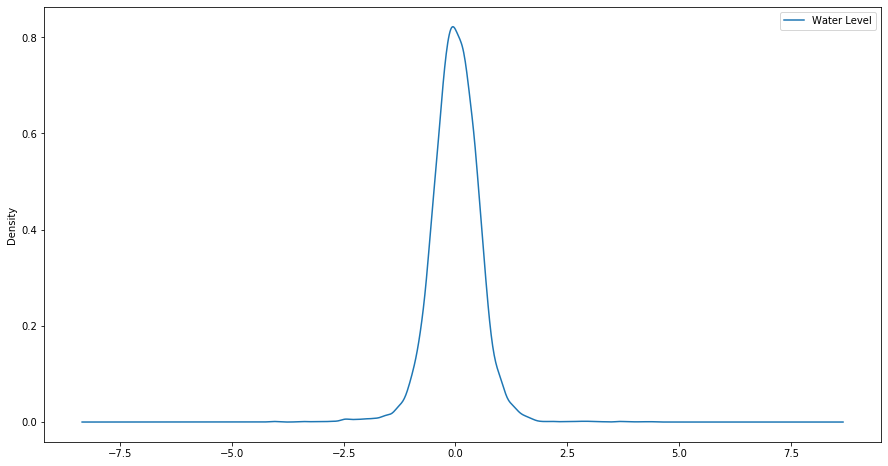

In [20]:
residuals.plot(figsize=(15,8))
residuals.plot(kind='kde', figsize=(15,8))
residuals.describe()

In [21]:
def plot_prediction(y_true, y_pred):
    plt.figure(figsize=(15,8))

    plt.plot(y_true)
    plt.plot(y_pred)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title('Water level data in 2020', fontsize=20)
    plt.ylabel('Water level', fontsize=16)
    
    last_month = y_pred.index[-1].month
    for month in range(1,last_month+1):
        plt.axvline(pd.to_datetime('2020-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)

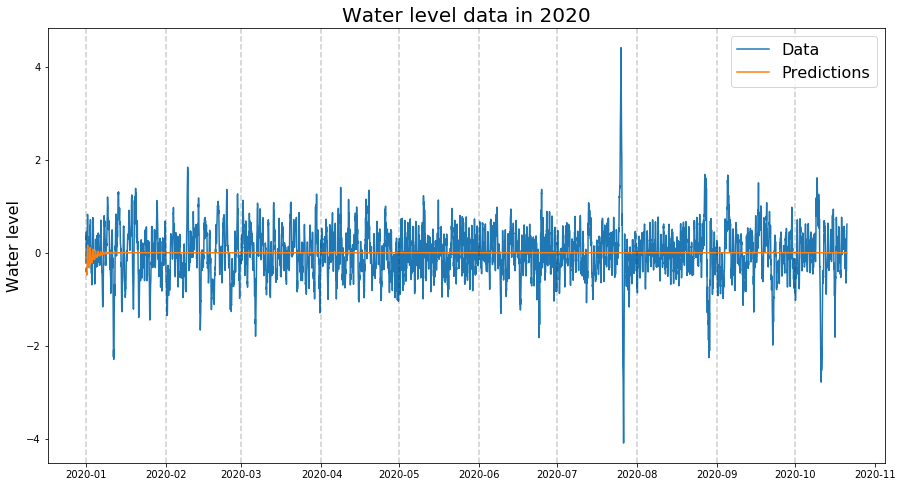

In [22]:
plot_prediction(wl_test, predictions)

We could clearly see that the prediction doesn't work quite well. I guess the model probably isn't suitable for predicting large amount of data.

## Evaluation

In [69]:
def undiff(arr, step=24):
    arr = arr.copy()
    for i in range(step, len(arr)):
        arr[i] += arr[i-step]
    return arr

def reconstruct(df):
    first_diff = orig_train.copy().set_index('Date Time')
    first_diff = first_diff.bfill().ffill().interpolate()
    first_diff = first_diff.diff(periods=24).dropna()
    
    res = df.values.copy()
    res = np.append(first_diff['Water Level'][-365*24:], res)
    res = undiff(res, 365*24)[365*24:]

    res = np.append(orig_train['Water Level'][-24:], res)
    res = undiff(res, 24)[24:]
    
    return pd.DataFrame(res, columns=['Water Level'], index=df.index)

In [79]:
def evaluate(pred, test, model='', use_true_label=False):
    # since we applied differencing earlier, it might be better if we revert them back
    if use_true_label:
        pred = reconstruct(pred)
        test = reconstruct(test)

        print(pred)
        print(test)
    
    mse = mean_squared_error(test, pred)
    r2 = r2_score(test, pred)
    mae = mean_absolute_error(test, pred)
    medae = median_absolute_error(test, pred)
    
    me = (test.values - pred.values).mean()
    
    errors = {'RMSE': sqrt(mse), 'R2': r2, 'MSE': mse, 'ME': me, 'MAE': mae, 'MedAE': medae}
    
    eval_df = pd.DataFrame(errors, index=[model]).round(3)
    return eval_df

In [80]:
evaluate(wl_test, predictions)

,RMSE,R2,MSE,ME,MAE,MedAE
,0.542,-516.758,0.294,-0.001,0.4,0.32


## Using the Rolling Forecast Origin

Since the above implementation didn't work, I decided to do a rolling forecast.  
Basically, it builds the  model, then predicts one day, then rebuilds the model, then predicts the next day, and so on.

The first model is with m = 24, which is the number of time steps for a single seasonal period.

In [56]:
def rolling_forecast_sarima(train, test, m=24, p=1, q=1, steps=None):
    history = [x for x in train['Water Level'].values]
    future = test['Water Level'].copy()
    rolling_pred = list()

    # time tracking
    start = time()

    if steps == None:
        steps = m
    total_steps = int(len(wl_test) / steps)

    for t in range(total_steps):
        print("Date: {}/{}".format(t, total_steps))
        print_elapsed_time(start)

        # train
        model_fit = train_sarima(history, periodicity=m, p=p, q=q)

        # predict
        output = model_fit.forecast(steps)
        yhat = output
        rolling_pred.extend(yhat)

        # add current day to training data
        obs = future[t*steps:(t+1)*steps].values
        history.extend(obs)

        clear_output(wait=True)
        # print(str(t) + '\npredicted={}\nexpected={}'.format(yhat, obs))

    clear_output(wait=True)
    print_elapsed_time(start)
    
    return rolling_pred

### SARIMA(0,1,0)(1,0,1)<sub>24</sub>

In [43]:
sarima_24_pred = rolling_forecast_sarima(wl_train, wl_test)

Elapsed time: 1:42:13


In [44]:
sarima_24_pred_df = pd.DataFrame(sarima_24_pred, columns=['Water Level'], index=wl_test[:len(sarima_24_pred)].index)
sarima_24_pred_df

,Water Level
Date Time,
2020-01-01 00:00:00,-0.443650
2020-01-01 01:00:00,-0.398570
2020-01-01 02:00:00,-0.361708
2020-01-01 03:00:00,-0.337178
2020-01-01 04:00:00,-0.399790
...,...
2020-10-20 19:00:00,0.497369
2020-10-20 20:00:00,0.390820
2020-10-20 21:00:00,0.315272


In [94]:
eval_sarima_24 = evaluate(wl_test[:len(sarima_24_pred_df)], sarima_24_pred_df, 'SARIMA(1,0,1,24)')
eval_sarima_24

,RMSE,R2,MSE,ME,MAE,MedAE
"SARIMA(1,0,1,24)",0.623,-0.459,0.388,0.033,0.463,0.377


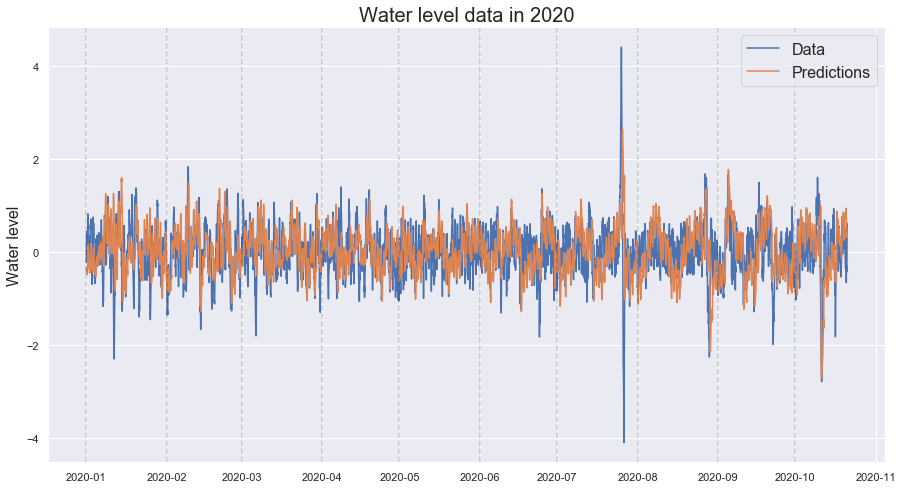

In [46]:
plot_prediction(wl_test, sarima_24_pred_df)

We could see that the prediction is much better, especially in the first half period. Unfortunately, the pattern starts to diverge in the second half period.

### SARIMA(0,1,0)(1,0,1)<sub>25</sub>

In [47]:
sarima_25_pred = rolling_forecast_sarima(wl_train, wl_test, m=25)

Elapsed time: 0:49:58


,RMSE,R2,MSE,ME,MAE,MedAE
"SARIMA(1,0,1,25)",0.638,-0.437,0.407,0.006,0.443,0.31


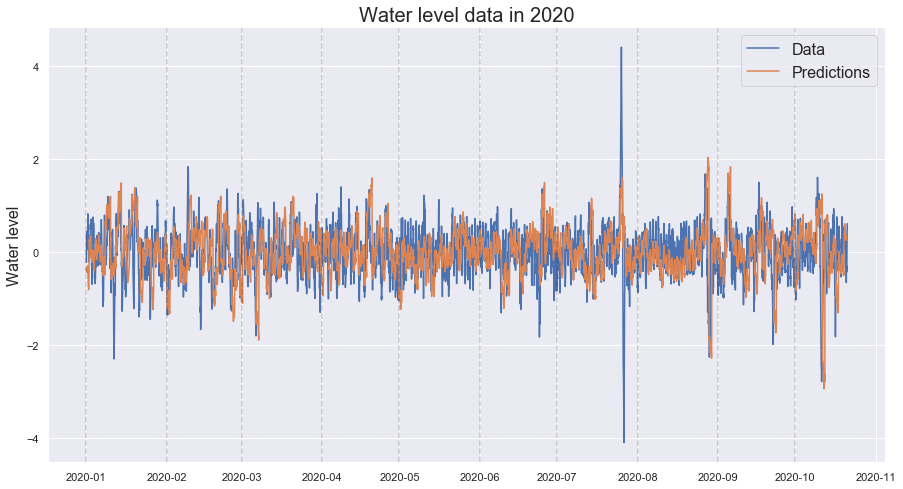

In [95]:
sarima_25_pred_df = pd.DataFrame(sarima_25_pred, columns=['Water Level'], index=wl_test[:len(sarima_25_pred)].index)
sarima_25_pred_df

plot_prediction(wl_test, sarima_25_pred_df)

eval_sarima_25 = evaluate(wl_test[:len(sarima_25_pred_df)], sarima_25_pred_df, 'SARIMA(1,0,1,25)')
eval_sarima_25

### SARIMA (0,1,0)(6,0,6)<sub>4</sub>

In [59]:
sarima_664_pred_3 = rolling_forecast_sarima(wl_train, wl_test, m=4, p=6, q=6, steps=24*3)

Elapsed time: 3:41:25


,RMSE,R2,MSE,ME,MAE,MedAE
"SARIMAX(6,0,6,4)",0.502,-2.834,0.252,0.01,0.356,0.272


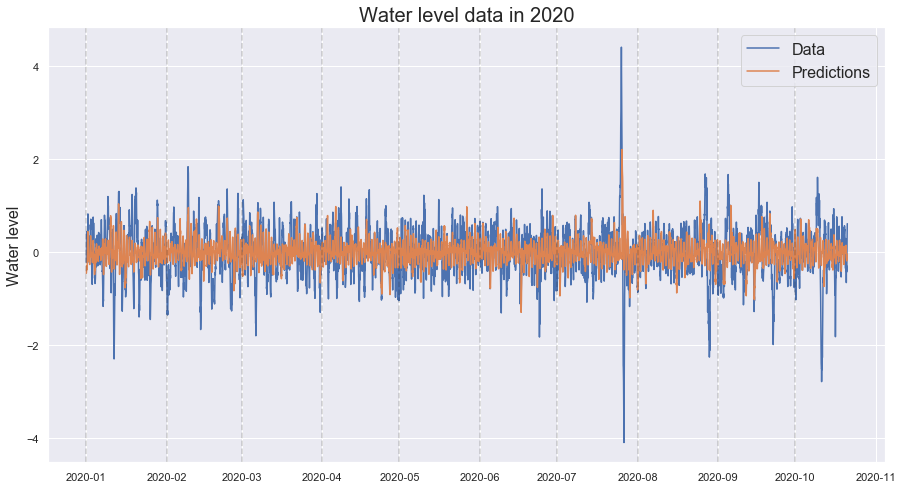

In [64]:
sarima_664_pred_3_df = pd.DataFrame(sarima_664_pred_3, columns=['Water Level'], index=wl_test[:len(sarima_664_pred_3)].index)
sarima_664_pred_3_df

plot_prediction(wl_test, sarima_664_pred_3_df)

eval_sarima_664_3 = evaluate(wl_test[:len(sarima_664_pred_3_df)], sarima_664_pred_3_df, 'SARIMAX(6,0,6,4)')
eval_sarima_664_3

In [67]:
sarima_664_pred = rolling_forecast_sarima(wl_train, wl_test, m=4, p=6, q=6, steps=24)

Elapsed time: 10:12:48


,RMSE,R2,MSE,ME,MAE,MedAE
"SARIMAX(6,0,6,4)",0.458,-0.441,0.21,0.012,0.322,0.245


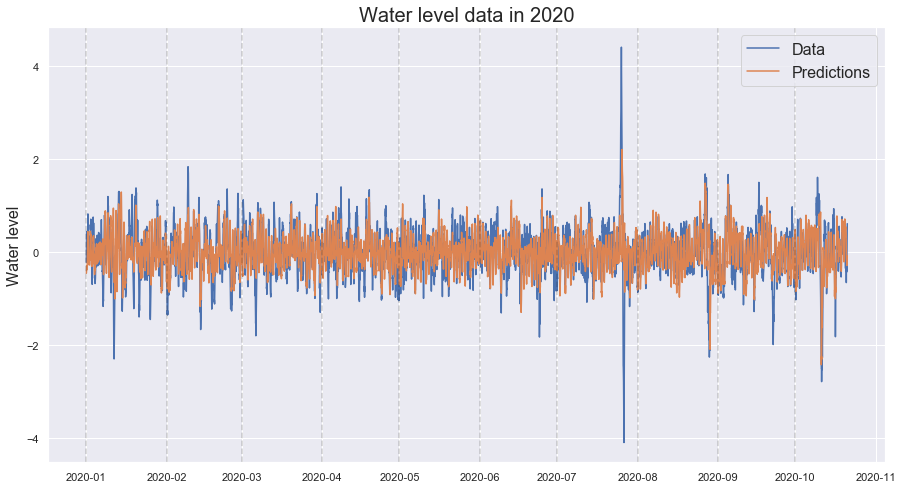

In [68]:
sarima_664_pred_df = pd.DataFrame(sarima_664_pred, columns=['Water Level'], index=wl_test[:len(sarima_664_pred)].index)
sarima_664_pred_df

plot_prediction(wl_test, sarima_664_pred_df)

eval_sarima_664 = evaluate(wl_test[:len(sarima_664_pred_df)], sarima_664_pred_df, 'SARIMAX(6,0,6,4)')
eval_sarima_664

In [110]:
evaluate(wl_test, sarima_664_pred_df, 'temp', use_true_label=True)

                     Water Level
Date Time                       
2020-01-01 00:00:00     1.534800
2020-01-01 01:00:00     1.636500
2020-01-01 02:00:00     1.705300
2020-01-01 03:00:00     1.627100
2020-01-01 04:00:00     1.598100
...                          ...
2020-10-20 21:00:00     1.858000
2020-10-20 22:00:00     2.366700
2020-10-20 23:00:00     2.721800
2020-10-21 00:00:00     2.967100
2020-10-21 01:00:00     3.091556

[7058 rows x 1 columns]
                     Water Level
Date Time                       
2020-01-01 00:00:00     1.298429
2020-01-01 01:00:00     1.029237
2020-01-01 02:00:00     1.021868
2020-01-01 03:00:00     0.893425
2020-01-01 04:00:00     0.936206
...                          ...
2020-10-20 19:00:00    -7.544061
2020-10-20 20:00:00    -6.175122
2020-10-20 21:00:00    -2.099080
2020-10-20 22:00:00     1.606744
2020-10-20 23:00:00    -2.820063

[7056 rows x 1 columns]


ValueError: Found input variables with inconsistent numbers of samples: [7056, 7058]

# SARIMA with exogenous  variables

## Correlation

In [26]:
def plot_corr(corr):
    sns.set(rc={'figure.figsize':(6,5)})
    ax = sns.heatmap(corr, cmap='Greens', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

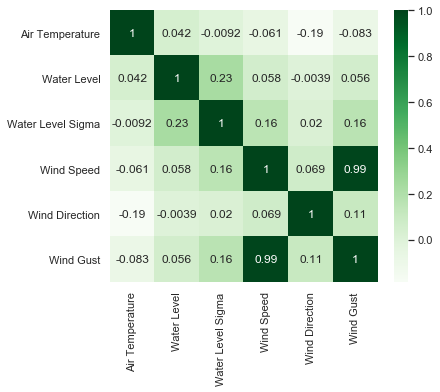

In [27]:
plot_corr(train.corr(method='spearman'))

Looking at the correlation between those attributes, Wind Speed and Wind Gust are highly correlated, so I decided to include only Wind Speed in the 2nd model.

## Training basic SARIMAX

In [28]:
model = SARIMAX(train['Water Level'], exog=train[['Wind Speed', 'Wind Direction']], \
                order=(0,1,0), seasonal_order=(1,0,1,24))
model_fit = model.fit()
model_fit.summary()

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Water Level   No. Observations:                17473
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 24)   Log Likelihood                6485.160
Date:                              Tue, 03 Nov 2020   AIC                         -12960.319
Time:                                      02:25:57   BIC                         -12921.478
Sample:                                  01-02-2018   HQIC                        -12947.528
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Wind Speed        -0.0011      0.000     -2.979      0.003      -0.002      -0.000
Wind Direction  2.249e-05   1.68e-05      1.337      0.181   -1.05e-05    5.54e-05
ar.S.L24           0.7575      0.010     74.062      0.000       0.737       0.778
ma.S.L24          -0.9756      0.010   -101.575      0.000      -0.994      -0.957
sigma2             0.0282      0.000    108.466      0.000       0.028       0.029
===================================================================================
Ljung-Box (L1) (Q):                 517.31   Jarque-Bera (JB):              2119.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Rolling Forecast

In [31]:
def train_sarimax_model(train, test, exogs, m=24, steps=None):
    history_wl = [x for x in train['Water Level'].values]
    history_exog = [x for x in train[exogs].values]
    future_wl = test['Water Level'].copy()
    future_exog = test[exogs].copy()

    sarimax_pred = list()

    # time tracking
    start = time()

    if steps == None:
        steps = m
    total_steps = int(len(wl_test) / steps)

    for t in range(total_steps):
        print('Date: {}/{}'.format(t, total_steps))
        print_elapsed_time(start)

        # train
        model = SARIMAX(history_wl, exog=history_exog, order=(0,1,0), seasonal_order=(1,0,1,m))
        model_fit = model.fit()

        # predict
        output = model_fit.forecast(steps, exog=future_exog[t:t+steps])
        yhat = output
        sarimax_pred.extend(yhat)

        # add current water level to training data
        obs = future_wl[t*steps:(t+1)*steps].values
        history_wl.extend(obs)
        # also the exog data
        history_exog.extend(future_exog[t*steps:(t+1)*steps].values)

        clear_output(wait=True)
        # print(str(t) + '\npredicted={}\nexpected={}'.format(yhat, obs))

    clear_output(wait=True)
    print_elapsed_time(start)
    
    return sarimax_pred

## SARIMAX(0,1,0)(1,0,1)<sub>24</sub> with Wind Speed and Direction

In [235]:
sarimax_24_wind_pred = train_sarimax_model(train, test, exogs=['Wind Speed', 'Wind Direction'])

Elapsed time: 7:00:19


In [297]:
sarimax_24_wind_pred_df = pd.DataFrame(sarimax_24_wind_pred, columns=['Water Level'], \
                                       index=wl_test[:len(sarimax_24_wind_pred)].index)
# sarimax_24_wind_pred_df

In [385]:
eval_sarimax_24_wind = evaluate(wl_test[:len(sarimax_24_wind_pred_df)], sarimax_24_wind_pred_df, 'SARIMAX_24_wind')
eval_sarimax_24_wind

,RMSE,R2,MSE,ME,MAE,MedAE
sarimax w/ wind,0.638,-0.588,0.407,0.009,0.475,0.389


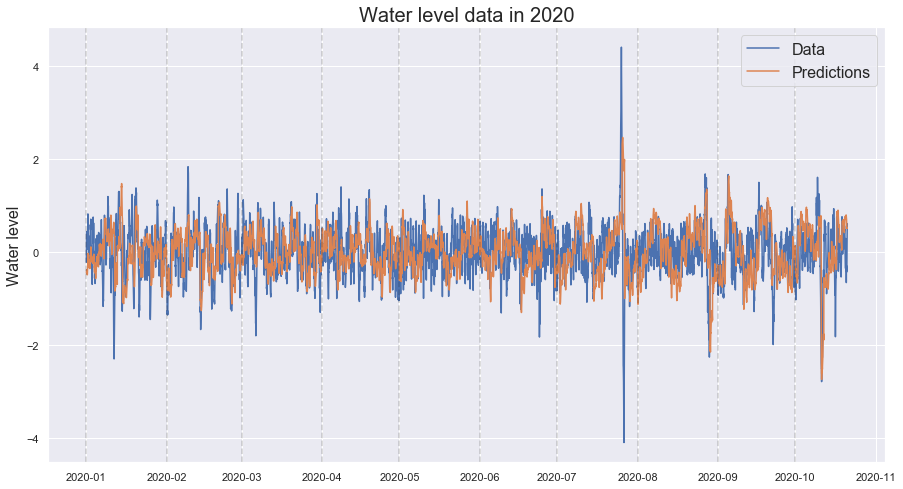

In [246]:
plot_prediction(wl_test, sarimax_pred_df)

The result doesn't have any significant difference from the previous model, while those errors metrics are slightly higher.

## SARIMAX(0,1,0)(1,0,1)<sub>25</sub> with Wind Speed, Water Level Sigma and Air Temp

In [50]:
exogs=['Wind Speed', 'Water Level Sigma', 'Air Temperature']
sarimax_25_full_pred = train_sarimax_model(train, test, exogs=exogs, m=25)

Elapsed time: 5:28:57


,RMSE,R2,MSE,ME,MAE,MedAE
SARIMAX_25 WS+WLS+AT,0.639,-0.436,0.408,0.005,0.443,0.308


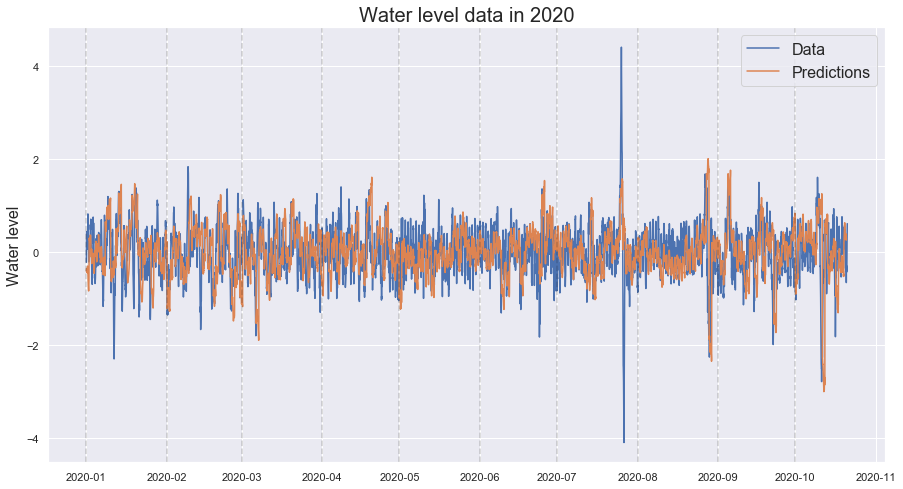

In [97]:
sarimax_25_full_pred_df = pd.DataFrame(sarimax_25_full_pred, columns=['Water Level'], \
                                       index=wl_test[:len(sarimax_25_full_pred)].index)

plot_prediction(wl_test, sarimax_25_full_pred_df)

eval_sarimax_25_full = evaluate(wl_test[:len(sarimax_25_full_pred_df)], sarimax_25_full_pred_df, 'SARIMAX_25 WS+WLS+AT')
eval_sarimax_25_full

# Final evaluation

In [108]:
eval_final = pd.concat([eval_sarima_24, eval_sarima_25, eval_sarima_664, eval_sarimax_24_wind, eval_sarimax_25_full])
eval_final.to_csv('metrics.csv')
eval_final

,RMSE,R2,MSE,ME,MAE,MedAE
"SARIMA(1,0,1,24)",0.623,-0.459,0.388,0.033,0.463,0.377
"SARIMA(1,0,1,25)",0.638,-0.437,0.407,0.006,0.443,0.310
"SARIMAX(6,0,6,4)",0.458,-0.441,0.210,0.012,0.322,0.245
SARIMAX_24 Wind,0.638,-0.588,0.407,0.009,0.475,0.389
SARIMAX_25 WS+WLS+AT,0.639,-0.436,0.408,0.005,0.443,0.308


In [107]:
sarima_24_pred_df.to_csv('1.csv')
sarima_25_pred_df.to_csv('2.csv')
sarima_664_pred_3_df.to_csv('3.csv')
sarima_664_pred_df.to_csv('4.csv')
sarimax_25_full_pred_df.to_csv('5.csv')